In [1]:
import re
import pandas as pd
from time import time
from collections import defaultdict
import spacy
from spacy import displacy

logging to use gensim

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## importing data
the data is Dr.Seuss' poems, quite short but anyways

data is in github repo

In [38]:
df = pd.read_csv('seuss.txt', sep="\n", header=None)
df.shape

(951, 1)

In [39]:
df.head()

,0
0,The Cat in the Hat
1,The sun did not shine.
2,It was too wet to play.
3,"So we sat in the house all that cold, cold, we..."
4,I sat there with Sally.


## preprocessing
lemmatizing, removing non-alphabetical characters

In [40]:
nlp = spacy.load('en')

In [41]:
#test loading to understand what is it
test_doc = nlp(df[0][3])
displacy.render(test_doc, style='dep')

In [42]:
def cleaning(doc):
    #removing stop-words and lemmatizing
    txt = [token.lemma_ for token in doc if not token.is_stop]
    #getting rid of small sentences
    if len(txt) > 2:
        return ' '.join(txt)

In [43]:
#generator for lower-case formatting
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower()
                 for row in df[0])

In [44]:
#cleaning&tokenizing
txt = [cleaning(doc) for doc in 
       nlp.pipe(brief_cleaning, batch_size=200, n_threads=-1)]

In [45]:
#the new clean dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(434, 1)

extracting frequently used phrases

In [46]:
from gensim.models.phrases import Phrases, Phraser

In [47]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count = 5)

2019-12-20 18:26:41,828 : INFO : collecting all words and their counts
2019-12-20 18:26:41,833 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-12-20 18:26:41,869 : INFO : collected 1832 word types from a corpus of 1955 words (unigram + bigrams) and 434 sentences
2019-12-20 18:26:41,872 : INFO : using 1832 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [48]:
bigrams = Phraser(phrases)
bigrams

2019-12-20 18:26:42,303 : INFO : source_vocab length 1832
2019-12-20 18:26:42,415 : INFO : Phraser built with 3 phrasegrams


In [49]:
sentences = bigrams[sent]
print(sentences)

In [50]:
#frequently found 2-word phrases
dubl = []
for sent in sentences:
    for word in sent:
        if '_' in word:
            dubl.append(word)
dubl = list(dict.fromkeys(dubl))
print(dubl)

['say_cat', 'mr_knox', 'tweetle_beetle']


extracting frequently used words

In [51]:
#creating a frequency dictionary
word_freq = defaultdict(int)
for sent in sentences:
    for word in sent:
        word_freq[word] += 1
len(word_freq)

571

In [52]:
#top-15 most frequently used words and their frequencies
top = sorted(word_freq, key=word_freq.get, reverse=True)[:15]
for word in top:
    print('{:10} {:10}'.format(word, word_freq[word]))

like               44
thing              43
sir                32
grinch             25
fish               24
come               23
hop                19
oh                 18
house              16
look               16
fun                15
box                15
tree               15
s                  15
see                14


In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

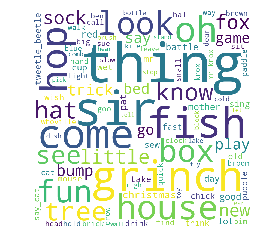

In [54]:
text = ''
for sent in sentences:
    for word in sent:
        text = text + str(word) + ' '
wc = WordCloud(background_color="white", max_words=100, max_font_size=200, width=800, height=800, collocations=False).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.show()

## training the model

In [55]:
import multiprocessing
from gensim.models import Word2Vec

In [56]:
#counting number of vectors
cores = multiprocessing.cpu_count()
cores

4

initializing the model

In [57]:
w2v_model = Word2Vec(min_count=3, window=2, size=60, sample=6e-5,
                    alpha=0.03, min_alpha=0.0007, negative=5,
                    workers=cores-1, batch_words=100)

building the vocabulary

In [58]:
t = time()
w2v_model.build_vocab(sentences, progress_per=50)
print('time to build vocab: {}'.format(round(time()-t, 2)))

2019-12-20 18:26:57,914 : INFO : collecting all words and their counts
2019-12-20 18:26:57,918 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-12-20 18:26:57,929 : INFO : PROGRESS: at sentence #50, processed 244 words, keeping 85 word types
2019-12-20 18:26:57,940 : INFO : PROGRESS: at sentence #100, processed 480 words, keeping 133 word types
2019-12-20 18:26:57,951 : INFO : PROGRESS: at sentence #150, processed 697 words, keeping 193 word types
2019-12-20 18:26:57,963 : INFO : PROGRESS: at sentence #200, processed 933 words, keeping 285 word types
2019-12-20 18:26:57,976 : INFO : PROGRESS: at sentence #250, processed 1178 words, keeping 389 word types
2019-12-20 18:26:57,985 : INFO : PROGRESS: at sentence #300, processed 1404 words, keeping 444 word types
2019-12-20 18:26:58,008 : INFO : PROGRESS: at sentence #350, processed 1591 words, keeping 478 word types
2019-12-20 18:26:58,018 : INFO : PROGRESS: at sentence #400, processed 1796 words, keeping 510

time to build vocab: 0.22


training the model

In [59]:
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count,
               epochs=20, report_delay=1)
print('time to train the model: {}'.format(round(time()-t, 2)))

2019-12-20 18:26:59,955 : INFO : training model with 3 workers on 221 vocabulary and 60 features, using sg=0 hs=0 sample=6e-05 negative=5 window=2
2019-12-20 18:27:00,085 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-20 18:27:00,090 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-20 18:27:00,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-20 18:27:00,096 : INFO : EPOCH - 1 : training on 1930 raw words (192 effective words) took 0.1s, 1664 effective words/s
2019-12-20 18:27:00,255 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-12-20 18:27:00,258 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-12-20 18:27:00,261 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-12-20 18:27:00,265 : INFO : EPOCH - 2 : training on 1930 raw words (172 effective words) took 0.1s, 1824 effective words/s
2019-12-20 18:27:00,368 : INFO : worker thread fini

time to train the model: 2.68


In [60]:
#normalizing L2-vectors !!after it training is impossible!!
w2v_model.init_sims(replace=True)

2019-12-20 18:27:04,560 : INFO : precomputing L2-norms of word weight vectors


## exploring the model
the results are quite bad, because the training set is extremely small

In [61]:
w2v_model.wv.most_similar(positive=['cat'])

[('near', 0.34406527876853943),
 ('fight', 0.3399798274040222),
 ('tomorrow', 0.33035677671432495),
 ('tall', 0.32342854142189026),
 ('snack', 0.2983878552913666),
 ('mr', 0.29446929693222046),
 ('wish', 0.2807488441467285),
 ('sound', 0.28034478425979614),
 ('grin', 0.2781240940093994),
 ('stack', 0.27428317070007324)]

In [62]:
w2v_model.wv.most_similar(positive=['come'])

[('slow', 0.3459196388721466),
 ('fight', 0.31478285789489746),
 ('start', 0.295508474111557),
 ('duck', 0.2890901565551758),
 ('isn', 0.2627774775028229),
 ('knox', 0.24687844514846802),
 ('ben', 0.23991160094738007),
 ('tick', 0.22928589582443237),
 ('mother', 0.20986279845237732),
 ('ask', 0.2085610330104828)]

In [70]:
w2v_model.wv.similarity('christmas', 'present')

0.053359315

## t-sne visualization

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

In [78]:
def tsne_plot(model, word, list_names):
    arrays = np.empty((0, 60), dtype='f')
    word_labels = [word]
    color_list = ['red']
    
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    close_words = model.wv.most_similar([word])
    
    for word_score in close_words:
        word_vec = model.wv.__getitem__([word_score[0]])
        word_labels.append(word_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, word_vec, axis=0)
        
    for word in list_names:
        word_vec = model.wv.__getitem__([word])
        word_labels.append(word)
        color_list.append('green')
        arrays = np.append(arrays, word_vec, axis=0)
        
    reduc = PCA(n_components=10).fit_transform(arrays)
    np.set_printoptions(suppress=True)
    y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    df = pd.DataFrame({'x': [x for x in y[:, 0]],
                      'y': [t for t in y[:, 1]],
                      'words': word_labels,
                      'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    p1 = sns.regplot(data=df, x='x', y='y', fit_reg=False, 
                     marker='o', scatter_kws={'s':40, 
                                             'facecolors': df['color']})
    
    for line in range(0, df.shape[0]):
        p1.text(df['x'][line], df['y'][line],
               ' ' + df['words'][line].title(),
               horizontalalignment='left', verticalalignment='bottom',
               size='medium', color=df['color'][line], 
                weight='normal').set_size(15)
        
    plt.xlim(y[:, 0].min()-50, y[:, 0].max()+50)
    plt.ylim(y[:, 1].min()-50, y[:, 1].max()+50)

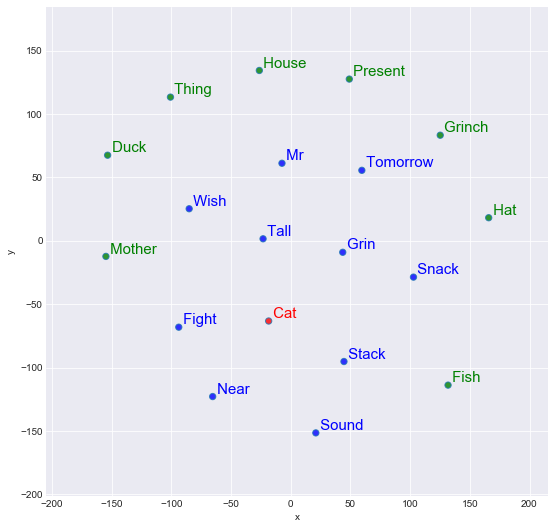

In [79]:
tsne_plot(w2v_model, 'cat', ['hat', 'fish', 'house', 'mother', 'thing', 'grinch', 'duck', 'present'])

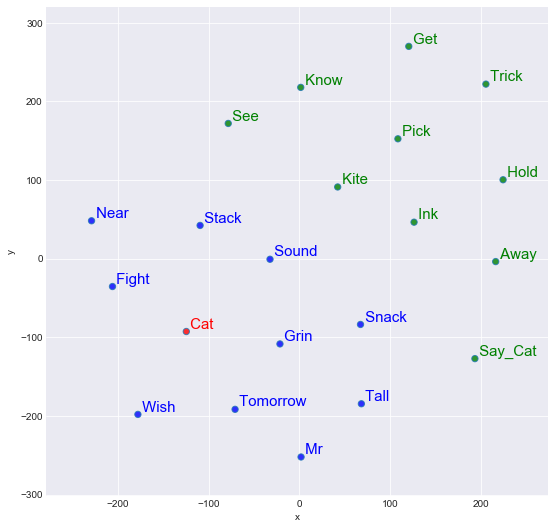

In [81]:
#most similar vs most dissimilar
tsne_plot(w2v_model, 'cat', 
          [i[0] for i in w2v_model.wv.most_similar(negative=['cat'])])